<a href="https://colab.research.google.com/github/ogiogidayo/EXB3-B/blob/main/qlab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit_aer pylatexenc

In [2]:
# 準備
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from sympy.physics.quantum.qubit import matrix_to_qubit
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

simulator = AerSimulator()
def get_statevector(circuit):
    circuit = circuit.copy()
    circuit=circuit.reverse_bits()
    circuit.save_statevector()
    circuit = transpile(circuit, backend=simulator)
    job = simulator.run(circuit)
    result = job.result()
    qiskit_statevector = result.data()['statevector']
    return np.asarray(qiskit_statevector) .reshape(-1,1)
def count_shots(circuit, shots):
    circuit = circuit.copy()
    circuit=circuit.reverse_bits()
    circuit = transpile(circuit, backend=simulator)
    return simulator.run(circuit, shots=shots).result().get_counts()

In [3]:
# kadai4a
def find_order(n, a):
    if math.gcd(a, n) != 1:
        return None
    r = 1
    while pow(a, r, n) != 1:
        r += 1
    return r


def myfactor(n):
    for a in range(2, n):
        if math.gcd(a, n) != 1:
            continue

        r = find_order(n, a)
        if r is None or r % 2 != 0:
            continue

        s = r // 2
        g1 = math.gcd(pow(a, s) - 1, n)
        g2 = math.gcd(pow(a, s) + 1, n)

        if g1 != 1 and g1 != n:
            return g1
        if g2 != 1 and g2 != n:
            return g2

    return None

# test
print(myfactor(n = 13 * 17))

13


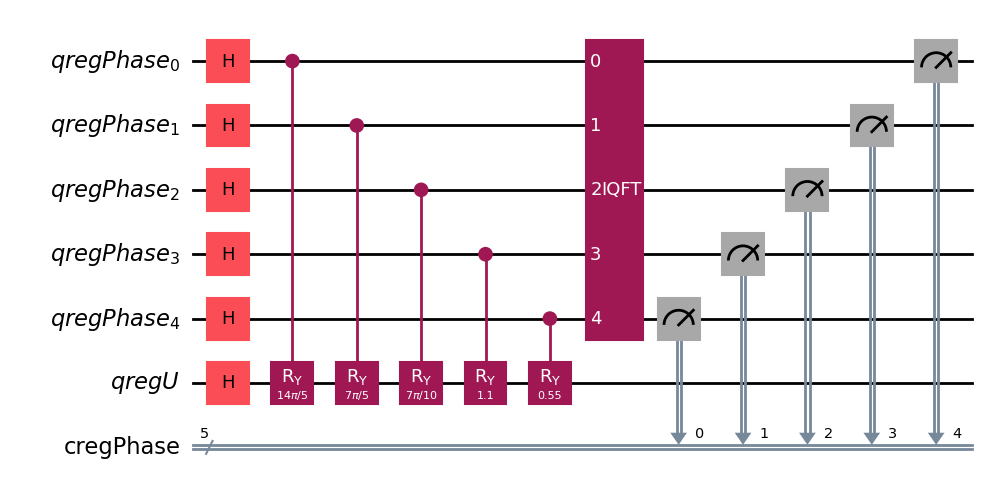

In [4]:
# kadai4b
qregPhase = QuantumRegister(5, name='qregPhase')
qregU = QuantumRegister(1, name='qregU')
cregPhase = ClassicalRegister(5, name='cregPhase')
circuit = QuantumCircuit(qregPhase, qregU, cregPhase)

circuit.h(qregPhase)
circuit.h(qregU)

theta = 4 * np.pi * 0.7

# 各ビットに対して制御された回転ゲートを適用
circuit.cry(theta / (2 ** 0), qregPhase[0], qregU[0])  # 制御 Ry を1回
circuit.cry(theta / (2 ** 1), qregPhase[1], qregU[0])  # 制御 Ry を2回
circuit.cry(theta / (2 ** 2), qregPhase[2], qregU[0])  # 制御 Ry を4回
circuit.cry(theta / (2 ** 3), qregPhase[3], qregU[0])  # 制御 Ry を8回
circuit.cry(theta / (2 ** 4), qregPhase[4], qregU[0])  # 制御 Ry を16回

qft = QFT(num_qubits=5, inverse=True).to_gate()
circuit.append(qft, qargs=qregPhase)

circuit.measure(qregPhase[::-1], cregPhase)

circuit.draw('mpl')

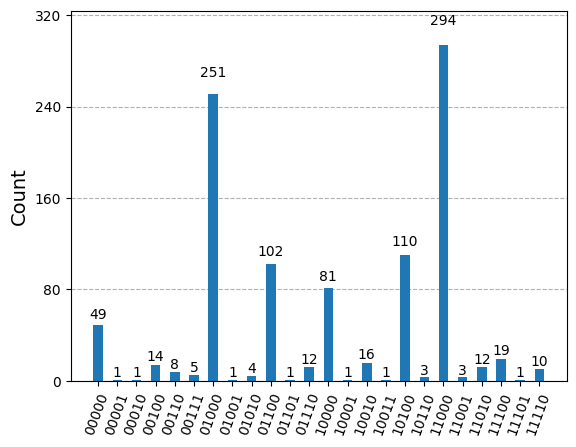

In [5]:
counts=count_shots(circuit,1000)
plot_histogram(counts)

In [6]:
# 考察
# 01000について
print(2 * math.pi * int('01000', 2) / (2**5))
# 11000について
print(2 * math.pi - (2 * math.pi * int('11000', 2) / (2**5)))
# よりほぼ同じ結果をえることができた

1.5707963267948966
1.5707963267948966


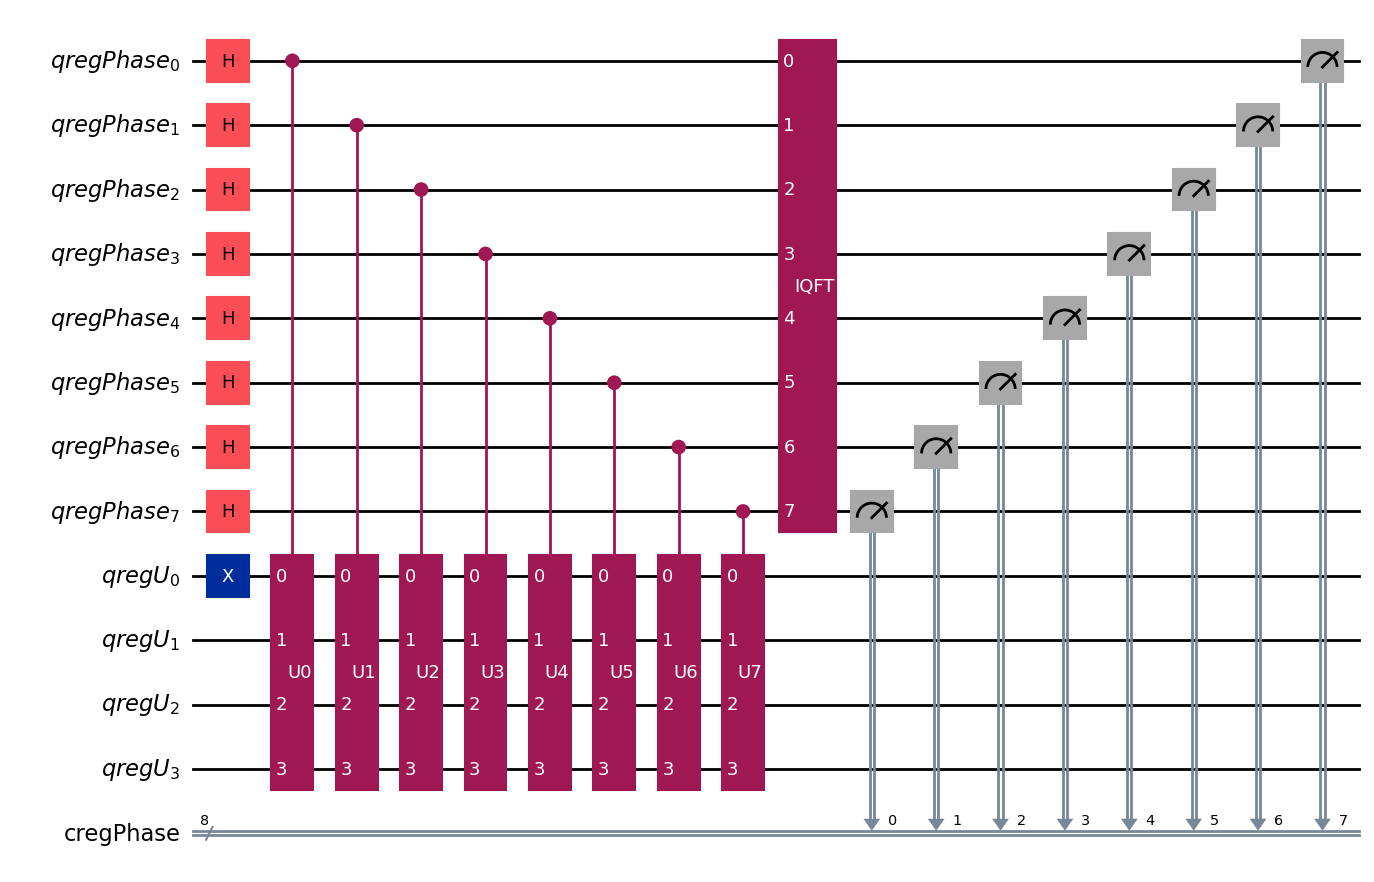

In [7]:
# kadai4c

# 量子レジスタと古典レジスタの定義
qregPhase = QuantumRegister(8, name='qregPhase')  # 位相を格納する量子レジスタ (8ビット)
qregU = QuantumRegister(4, name='qregU')  # U を計算する量子レジスタ (4ビット)
cregPhase = ClassicalRegister(8, name='cregPhase')  # 位相を格納する古典レジスタ (8ビット)
circuit = QuantumCircuit(qregPhase, qregU, cregPhase)

# ハダマードゲートと初期化
circuit.h(qregPhase)  # 位相レジスタにハダマードゲートを適用
circuit.x(qregU[0])   # 計算レジスタの初期化

# f(x) を計算するミニ量子回路 U を定義
U = QuantumCircuit(4)
U.swap(1, 0)
U.swap(2, 1)
U.swap(3, 2)
U.x([0, 1, 2, 3])

# 制御 U を 2**i 回繰り返す
for i in range(8):
    circuit.append(U.repeat(2**i).to_gate(label=f"U{i}").control(), qargs=[qregPhase[i]] + qregU[:])

# 量子フーリエ逆変換 (QFT) の適用
qft = QFT(num_qubits=8, inverse=True).to_gate()
circuit.append(qft, qargs=qregPhase)

# 測定操作
circuit.measure(qregPhase[::-1], cregPhase)

# 回路図の描画
circuit.draw('mpl')

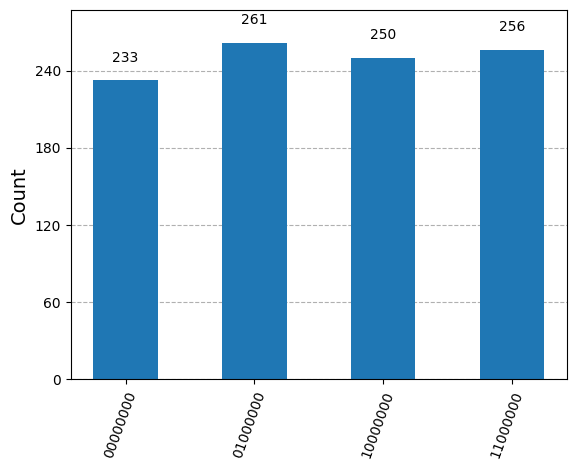

In [8]:
# シミュレーションの実行と結果のプロット
counts=count_shots(circuit,1000)
plot_histogram(counts)

In [9]:
print(int('00000000', 2))
print(int('01000000', 2))
print(int('10000000', 2))
print(int('11000000', 2))

0
64
128
192


In [10]:
print(0/2**8)
print(64/2**8)
print(128/2**8)
print(192/2**8)

0.0
0.25
0.5
0.75


In [11]:
measured_values = [int(key[::-1], 2) for key in counts.keys()]

x = max(measured_values, key=lambda k: counts[format(k, '08b')[::-1]])

# 位数rの推定: x / 256 が s/r に対応するので有理数近似で r を求める
N = 256  # 位相レジスタが8ビットなので2^8 = 256
fraction_approximation = x / N

# 有理数近似 (例えばr=4）
r = 4

# 素因数分解
N = 15
a = 7

factor_1 = math.gcd(a**(r//2) - 1, N)
factor_2 = math.gcd(a**(r//2) + 1, N)

print(f"15 の素因数：{factor_1}, {factor_2}")

15 の素因数：3, 5


In [12]:
# kadai4d
import scipy.linalg as LA

def div(rho, sigma):
    rho_inv = LA.inv(sigma)
    rho_sigma = rho @ rho_inv
    rho_sigma_log = LA.logm(rho_sigma)
    trace_term = np.trace(rho @ rho_sigma_log)
    return trace_term

rho = np.array([[0.2, 0.02], [0.02, 0.8]])
sigma = np.array([[0.5, 0.1], [0.1, 0.5]])

result_div = div(rho, sigma), div(sigma, rho), div(rho, rho), div(sigma, sigma)

print(div(rho, sigma))
print(div(sigma, rho))
print(div(rho, rho))     # ほぼ0
print(div(sigma, sigma)) # ほぼ0

0.2113307152375909
0.2415691720500855
-2.2194026065579964e-17
-1.0639637319324416e-18


In [14]:
# ★証明

# 古典的な相対エントロピー
def classical_relative_entropy(p, q):
    return np.sum(p * np.log(p / q))

# 量子相対エントロピーの計算
def quantum_relative_entropy(rho, sigma):
    rho_log = LA.logm(rho)
    sigma_log = LA.logm(sigma)
    rho_sigma_log = rho_log - sigma_log
    trace_term = np.trace(rho @ rho_sigma_log)
    return trace_term

# 確率分布の定義（古典的な場合）
p = np.array([0.2, 0.3, 0.5])
q = np.array([0.1, 0.4, 0.5])

# 対角行列の定義（量子的な場合）
rho = np.diag(p)
sigma = np.diag(q)

# 古典的な相対エントロピーの計算
classical_entropy = classical_relative_entropy(p, q)

# 量子相対エントロピーの計算
quantum_entropy = quantum_relative_entropy(rho, sigma)

print('古典的な相対エントロピー D(p || q):', classical_entropy)
print('量子相対エントロピー D(rho || sigma):', quantum_entropy)
# ほとんど一致する


古典的な相対エントロピー D(p || q): 0.05232481437645474
量子相対エントロピー D(rho || sigma): 0.05232481437645471
